In [1]:
import os
from pathlib import Path

from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt


from model_deployment.prove import Summary, StraightLineSummary

from evaluation.eval_analysis import (
    EvalDesc,
    EvalData,
    load_evals,
    find_mutual_proofs,
    PlotPoint,
    ProofPair,
    count_total_successes,
    get_two_eval_subsets,
    get_three_eval_subets,
    a_beats_b_generator,
)

In [2]:
if Path(os.curdir).resolve().name == "evaluation":
    os.chdir("../..")
elif Path(os.curdir).resolve().name == "coq-modeling": 
    pass
else:
    raise ValueError(f"In an unexpected directory: {os.curdir}")
    


In [3]:
EVALS = [
    # EvalDesc("Proofs + Premises", "deepseek-proof-prem-full-train-500-10min"),
    # EvalDesc("Proofs Only", "deepseek-proof-500"),
    # EvalDesc("Premises Only", "deepseek-prem-500"),
    EvalDesc("Slurm Basic", "deepseek-slurm-final-500"),
    EvalDesc("Local Basic", "deepseek-local-final-500"),

]
RESULTS_LOC = Path("evaluations/eval-results")
raw_evals = load_evals(EVALS, RESULTS_LOC)

## Proof Count (Sanity Check)

In [4]:
mutual_proofs = find_mutual_proofs(raw_evals)
evals = [e.filter_to_proofs(mutual_proofs) for e in raw_evals]
assert all(len(e.results) == len(mutual_proofs) for e in evals)
print("Mutual proofs:", len(mutual_proofs))

Mutual proofs: 500


## Count Error Fraction

In [5]:
for e in evals:
    print(e.alias, e.get_error_fraction())

Slurm Basic 0.038
Local Basic 0.03


## Proofs over Time

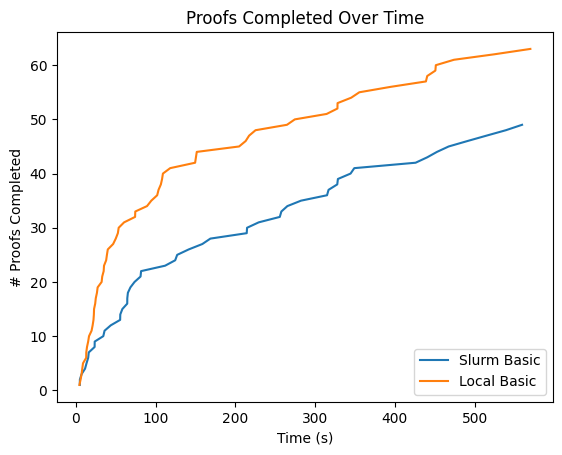

In [6]:
def plot_times(es: list[EvalData]):
    times = [e.get_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed Over Time")
    ax.legend(loc="lower right")


plot_times(evals)

# Proofs Completed over Model Time

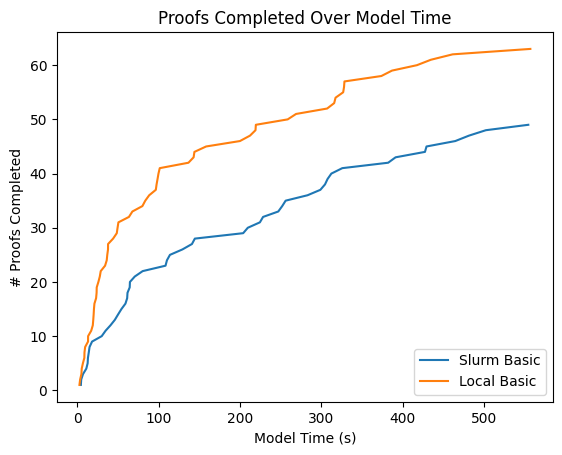

In [15]:
def plot_model_times(es: list[EvalData]):
    times = [e.get_model_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("Model Time (s)")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed Over Model Time")
    ax.legend(loc="lower right")


plot_model_times(evals)

## Proofs over Attempts

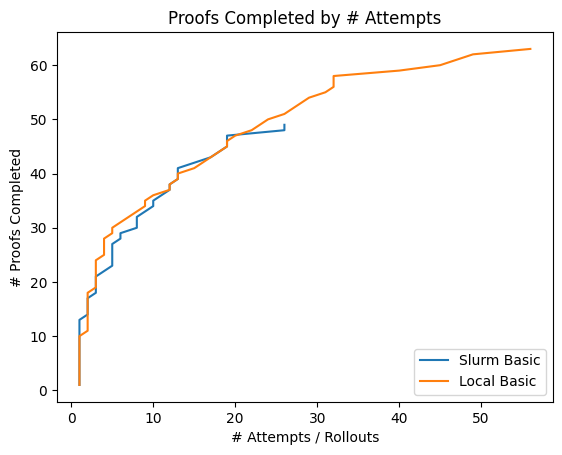

In [8]:
def plot_attempts(es: list[EvalData]):
    attempts = [e.get_attempts_points() for e in es]
    fig, ax = plt.subplots()
    for e, attempt_list in zip(es, attempts):
        xs = [t.x for t in attempt_list]
        ys = [t.y for t in attempt_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("# Attempts / Rollouts")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed by # Attempts")
    ax.legend(loc="lower right")


plot_attempts(evals)

## Overlap Comparison

In [9]:
print("Total # Theorems Found: ", count_total_successes(evals))

Total # Theorems Found:  68


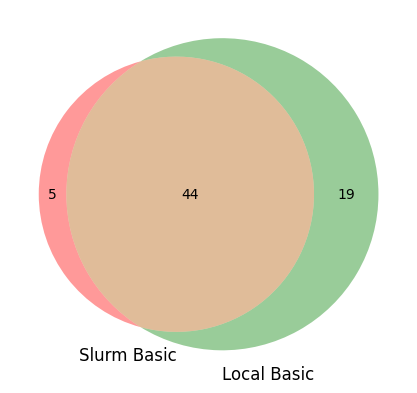

In [10]:
def compare_two(es: list[EvalData], e1_alias: str, e2_alias: str):
    fig, ax = plt.subplots()
    subsets = get_two_eval_subsets(es, e1_alias, e2_alias)
    venn2((len(subsets.one_only), len(subsets.two_only), len(subsets.one_two)),
          set_labels=(e1_alias, e2_alias), ax=ax)


def compare_three(es: list[EvalData], e1_alias: str, e2_alias: str, e3_alias: str):
    fig, ax = plt.subplots()
    subsets = get_three_eval_subets(es, e1_alias, e2_alias, e3_alias)
    venn3((len(subsets.one_only), len(subsets.two_only), len(subsets.one_two),
              len(subsets.three_only), len(subsets.one_three), len(subsets.two_three),
              len(subsets.one_two_three)),
             set_labels=(e1_alias, e2_alias, e3_alias), ax=ax)

compare_two(evals, "Slurm Basic", "Local Basic")

# Inspect Individual Results

In [11]:
A = "Local Basic"
B = "Slurm Basic"
better_gen = a_beats_b_generator(evals, A, B)

In [12]:
def display_diff(p: ProofPair, e1_alias: str, e2_alias: str, s1: Summary, s2: Summary):
    print(f"{e1_alias} beat {e2_alias} on {p.theorem_name} from {p.file_name}")
    assert s1.success == True
    if isinstance(s1, StraightLineSummary):
        assert s1.attempts is not None
        print(f">>>>> {e1_alias} found a proof in {s1.search_time} seconds ({s1.model_time} model seconds) and {len(s1.attempts)} attempts.")
    else:
        print(f">>>>> {e1_alias} found a proof in {s1.search_time} seconds ({s1.model_time} model seconds)")

    assert s1.proof is not None
    print(s1.proof)

    print()
    if s2.search_time is None:
        print(f"<<<<< {e2_alias} failed with an error.")
        return
    if isinstance(s2, StraightLineSummary):
        assert s2.attempts is not None
        print(f"<<<<< {e2_alias} failed after {s2.search_time} seconds ({s1.model_time} model seconds) and {len(s2.attempts)} attempts.")
        for a in s2.attempts: 
            print(a)
    else:
        print(f"<<<<< {e2_alias} failed after {s2.search_time} seconds ({s1.model_time} model seconds)")


In [13]:
p, s1, s2 = next(better_gen)
display_diff(p, A, B, s1, s2)


Local Basic beat Slurm Basic on lt_factorial_O-0 from raw-data/coq-dataset/repos/coq-community-bertrand/theories/Factorial_bis.v
>>>>> Local Basic found a proof in 150.5211043357849 seconds and 16 attempts.
Theorem lt_factorial_O : forall n : nat, 0 < factorial n.
Proof.
  induction n; simpl; auto with arith.
Qed.

<<<<< Slurm Basic failed after 607.1857740879059 seconds and 25 attempts.

Proof.
  induction n; auto with arith.
  rewrite <- lem.S_plus in IHn.

Proof.
  intro; induction  n as [| n Hrecn].
  simpl; reflexivity.

Proof.
  intros n.
  induction n.
  - simpl.
    apply lt_0_Sn.
  - rewrite factorial_succ.

Proof.
  intros n.
  apply lt_factorial.

Proof.
  induction n.
    - simpl in |- *. auto with arith.
    - simpl in |- *. apply lt_le_trans with (S n).
        auto with arith.
        apply plus_pattern.

Proof. induction n.
   - apply O_le_factorial.

intros;apply lt_O_factorial; apply odd_factorial; exact (factorial_minus_even_odd n).

  Proof.
    induction n.
    - s